# Dynamic Hedging

In dynamic hedging, the hedger rehedges at discrete, evenly spaced time intervals as the underlying stock changes. In this exercise, it is assumed that the underlying stock price evolves lognormally with a constant volatility σ per the Black Scholes model.

The Black Scholes formula postulates that if properly hedged, the hedger should end up with a final profit of zero. A replication error occurs when the final value deviates from zero.

Reference: http://pricing.free.fr/docs/when_you_cannot_hedge.pdf

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import datetime as dt

from scipy.stats import norm
from scipy.optimize import brentq
from scipy.optimize import least_squares
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

## Delta Hedging

Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position through a combination of the underlying stock and risk-free bond. 

The equation for the hedged portfolio is given by:
$$V_{t} = \phi_{t}S_{t} + \psi_{t}B_{t}$$

where 
$$\phi_{t} = \Delta_{t} = \frac{\partial C}{\partial S} = \Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)$$

and
$$\psi_{t}B_{t} = -Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)$$

In [2]:
def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)

def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

## Hedging Error

For this Monte Carlo simulation, the effect of dropping Black Scholes key assumption of continuous hedging is examined. With discrete instead of continuous rebalancing, the hedge will be imperfect and result in an inexact replication, since the market price of stock and bonds will change over time. This imperfection may sometimes result in gains, and other times in losses. As the frequency of hedging increases, it is expected that this error should become smaller.

In [3]:
def calculate_hedging_error(T, blackscholespath, maturity, K, r, sigma, dt):
    """
    Calculates the hedging errors for a list of simulated Black-Scholes paths

    Parameters
    ----------
    T: Array[float]
    Array of discrete hedging time intervals

    blackscholespath: Array[Array[float]]
    Array of stock price processes each representing a single simulated stock price path

    maturity: float
    Option time to maturity (in years)

    K: float
    Strike price

    r: float
    Discount rate

    sigma: float
    Underlying stock price volatility

    dt: float
    Remaining time to maturity (in years)

    Returns
    -------
    errors: Array[Array[float]]
    Returns a 2D-array of hedging errors at each discrete hedging point for all simulated paths
    """
    errors = np.zeros((len(blackscholespath), len(T)))

    for idx, time_step in np.ndenumerate(T):
        # Calculate current stock and bond position at each hedge interval
        # for all simulated stock price paths
        curr_phi = phi(blackscholespath[ : , idx[0]],
                       K,
                       r,
                       sigma,
                       maturity-time_step)
        stock_pos = curr_phi * blackscholespath[ : , idx[0]]
        bond_pos = psi_Bt(blackscholespath[ : , idx[0]],
                          K,
                          r,
                          sigma,
                          maturity-time_step)
        # Calculate the hedging error between current and previous hedge interval
        # for all simulated stock price paths
        if idx[0] == 0:
            errors[ : , idx[0]] = 0.0
        else:
             errors[ : , idx[0]] = ((prev_phi*blackscholespath[ : , idx[0]] - stock_pos) +
                                    (prev_bond_pos*np.exp(r*dt) - bond_pos)
                                   )
        prev_phi = curr_phi
        prev_bond_pos = bond_pos

    return errors

### Parameters

In [4]:
maturity = 1/12
r = 0.05
S0 = 100.0
K = 100.0
sigma = 0.2

PATHS = 50000
HEDGES_NUM = [21, 84]

### Functions

In [5]:
def simulate_Brownian_Motion(paths, steps, T):
    """
    Simulates Brownian Motion paths over a period with discrete steps.

    Parameters
    ----------
    paths: int
    Number of desired Brownian Motion paths

    steps: int
    Number of discrete intervals across time period

    T: float
    Time duration (in years)

    Returns
    -------
    t, simulated_motion: Array[float], Array[Array[float]]
    Returns an array of discrete intervals and a 2D-array of simulated Brownian Motion paths
    """
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    simulated_motion = np.cumsum(np.sqrt(deltaT) * X, axis=1)
    return t, simulated_motion

In [6]:
def BlackScholesCall(S, sigma, K, r, T):
    d1 = (np.log(S/K) + (r+0.5*(sigma**2))*T) / (np.sqrt(T) * sigma)
    d2 = d1 - np.sqrt(T) * sigma
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

### Hedge for N = 21 and N = 84

A comparison between one versus four hedges per day, assuming 21 trading days in a month.

In [7]:
hedging_error = {}

for hedges in HEDGES_NUM:
    dt = maturity / hedges
    
    # Simulate stock price process
    T, W_T = simulate_Brownian_Motion(PATHS, hedges, maturity)
    blackscholespath = S0 * np.exp((r-sigma**2/2)*T + sigma*W_T)
    
    # Calculate the hedged portfolio error for simulated stock price processes for each n hedge times
    hedging_error[f"{hedges}"] = calculate_hedging_error(T, blackscholespath, maturity, K, r, sigma, dt)

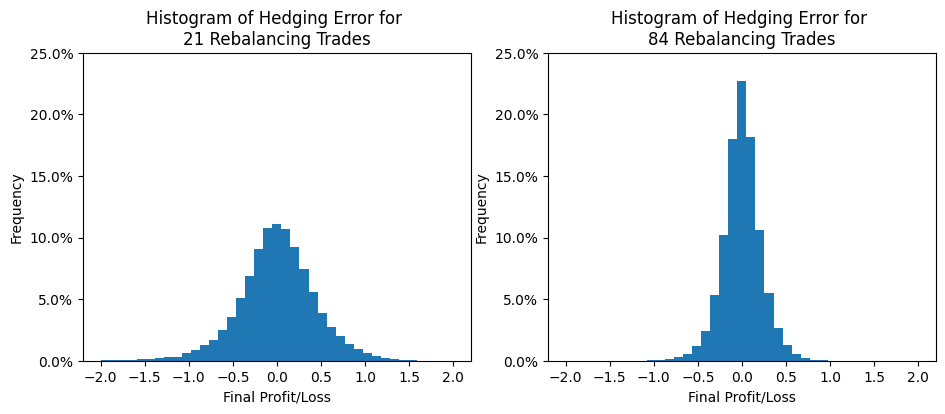

In [8]:
plt.figure(figsize = (11,4))
plot_num = 1
for N, errors in hedging_error.items():
    plt.subplot(1,2,plot_num)
    plt.hist(errors.sum(axis = 1),
             weights = np.ones(len(errors.sum(axis=1)))/len(errors.sum(axis=1)),
             bins = np.linspace(-2,2,40)
            )
    plt.title(f'Histogram of Hedging Error for \n{N} Rebalancing Trades')
    plt.xlabel('Final Profit/Loss')
    plt.ylabel('Frequency')
    plt.yticks(np.arange(0,0.3,0.05))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plot_num += 1

## Results

The results show that the mean and standard deviation of hedging errors reduce (tend towards 0) as the hedging frequency increases.

In [9]:
mean_PL = np.zeros(len(HEDGES_NUM))
std_PL = np.zeros(len(HEDGES_NUM))
std_option_premium = np.zeros(len(HEDGES_NUM))

BS_option_price = BlackScholesCall(S0, sigma, K, r, maturity)

for idx, (N, errors) in enumerate(hedging_error.items()):
    mean_PL[idx] = errors.sum(axis = 1).mean()
    std_PL[idx] = errors.sum(axis = 1).std()
    std_option_premium[idx] = std_PL[idx]/BS_option_price*100

In [10]:
result = pd.DataFrame({"Hedges": HEDGES_NUM,
                       "Mean PL": mean_PL,
                       "Standard Deviation of PL": std_PL,
                       "Standard Deviation of P&L (% option premium)": std_option_premium})
result

,Hedges,Mean PL,Standard Deviation of PL,Standard Deviation of P&L (% option premium)
0,21,0.003000,0.430893,17.152915
1,84,0.000436,0.217237,8.647748
